# **PLN Proyecto Final**



> En caso de solamante querer evaluar el modelo, cargando ya un modelo guardado, con datos de testeo para usar el modelo, ejecuta la seccion:
* 1. Importación de librerías
* 5. Limpieza y Preprocesamiento
* pasa a la seccion 12. PROBANDO EL MODELO



> Si quieres entrenar de nuevo un modelo, sigue los pasos, para entrenar un modelo a partir de un lote distinto de datos o bien la muestra de datos con la que se entreno el modelo, las instrucciones a partir de la seccion 2 de esta libreta, ejecuta primereo la seccion 1.






## 1. Importación de librerías

In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
import re
from string import punctuation
from bs4 import BeautifulSoup  # Librería útil para manejar HTML

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.metrics import accuracy_score, precision_recall_fscore_support



---



## 2. Descargando datos y preparación inicial del dataset



> En caso de querer descargar los datos originales y realizar el proceso de tomar una nueva muestra para entrenar favor de descomentar cada paso , en caso contrario pasar a la seccion B y cargar un archivo sample_raw




> Esta parte se puede omitir al menos que no se tenga el sample del conjunto de datos con lo que se entreno el modelo, entonces se procede a descargar el dataset original y prepararlo para trabjar con el.


> Pasa a la Seccion B en caso de que tenga ya un archivo de mueestra

PASO 1

In [ ]:
#!gdown 1Kve4q1mpp-EYxAOfKO3lwUAwpYon7_s_ #DESCOMENTA EN CASO DE NECESITARLO

Downloading...
From (original): https://drive.google.com/uc?id=1Kve4q1mpp-EYxAOfKO3lwUAwpYon7_s_
From (redirected): https://drive.google.com/uc?id=1Kve4q1mpp-EYxAOfKO3lwUAwpYon7_s_&confirm=t&uuid=d5128969-4cc7-4377-bd7f-4f6c511a95dc
To: /content/final-train.csv
100% 199M/199M [00:00<00:00, 216MB/s]


PASO 2

In [ ]:
#df = pd.read_csv('final-train.csv') #DESCOMENTA EN CASO DE NECESITARLO
#df #DESCOMENTA EN CASO DE NECESITARLO

,Summary,Text,Score
0,Can really notice when I am not drinking it,I have had hormone problems in the past couple...,5
1,"Okay, just not the best",This is a decent balsamic glaze/reducation.<br...,4
2,"goo source of fiber, not so much a source of c...",the cookie is moist and chewy and has a great ...,3
3,Great GF Staple,I have a 4 yr old and a 2 yr old that can't ea...,5
4,Coffee just doesn't taste right without Sweet ...,We have drunk our coffee for 45 years using th...,5
...,...,...,...
426335,funnel cake mix,This is very good and just like the gourmet on...,4
426336,Yummy Fruit Snacks,I bought these for my kids but find myself eat...,5
426337,Great coffee,eight oclock makes great coffee and with balan...,5
426338,Earl Grey of Earl Grey +++,I already liked regular Stash Earl Grey and so...,5


PASO 3

In [ ]:
#df['Negative'] = df['Score'].apply(lambda x: 1 if x < 3 else 0) #DESCOMENTA EN CASO DE NECESITARLO



> Se Crearon etiquetas binarias: Se creo una nueva columna Negative para identificar opiniones negativas (calificaciones de 1 y 2) como 1, y las demás como 0.



In [ ]:
#df.info() #DESCOMENTA EN CASO DE NECESITARLO

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426340 entries, 0 to 426339
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   Summary   426323 non-null  object
 1   Text      426340 non-null  object
 2   Score     426340 non-null  int64 
 3   Negative  426340 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 13.0+ MB


## 3. Balanceo del dataset

> Para evitar un desbalance en clases:
  * Muestreo estratificado:
  Se seleccionan un 51% de opiniones negativas y un 49% de no negativas. Esto debido a que nos interesa y es parte de los objetivos del proyecto que identifique mejor los comnentarios negativos y con esto podemos ligeramente balancear de un lado que nos interesa sin comprometer el apredizaje de los no negativos.
  * Muestra: Se procede a tomar una muestra del conjunto original, esto para poder trabajar con la gpu y los tiempos de entrenamiento disminuirlo.

PASO 4

In [ ]:
def generar_muestra(df):
  # Fracción para la muestra total
  frac_total = 0.2

  # Proporciones aproximadas para negativos y no negativos
  neg_frac = 0.51  # 55% negativos
  non_neg_frac = 0.49  # 45% no negativos (0 en la columna Negative)

  # Dividiendo el dataset en negativos (1) y no negativos (0)
  negativos = df[df['Negative'] == 1]
  no_negativos = df[df['Negative'] == 0]

  # Calculando el tamaño total de la muestra
  sample_size = int(len(df) * frac_total)

  # Calculando el tamaño de las muestras para negativos y no negativos
  neg_sample_size = int(sample_size * neg_frac)
  non_neg_sample_size = int(sample_size * non_neg_frac)

  # Tomando muestras de cada clase
  neg_sample = negativos.sample(n=neg_sample_size, random_state=42)
  non_neg_sample = no_negativos.sample(n=non_neg_sample_size, random_state=42)

  # Combinando las muestras
  balanced_sample = pd.concat([neg_sample, non_neg_sample])

  # Barajareamos la muestra combinada (opcional, aqui lo incluimos)
  balanced_sample = balanced_sample.sample(frac=1, random_state=42).reset_index(drop=True)

  return balanced_sample

  # Resultado: Verificando el balance de la muestra
  print("Distribución de la muestra balanceada:")
  print(balanced_sample['Negative'].value_counts())

  # Resultado final
  balanced_sample.head()

Distribución de la muestra balanceada:
Negative
1    43486
0    41781
Name: count, dtype: int64


,Summary,Text,Score,Negative
0,Very pleased with this product,Since we discovered this product through Amazo...,5,0
1,Great,My dogs have loved this product for 22+ Years....,5,0
2,"Fat free and taste free, sorry to say!",REally wanted to like this but it has no taste...,1,1
3,good stuff!,I really enjoy this product--I just purchased ...,5,0
4,HOW CAN YOU GO WRONG WITH GREENIES,Greenies are a great way to train your cat. If...,5,0


PASO 4

Guardando la muestra de datos con los que se va trabajar despues de que se transformo y se eligio aleatoriamente los datos.

In [ ]:
#balanced_sample = generar_muestra(df) #DESCOMENTA EN CASO DE NECESITARLO

# Guardar en CSV
#balanced_sample.to_csv("sample_raw.csv") #DESCOMENTA EN CASO DE NECESITARLO



---



### Seccion B

---
> * Si se cuenta con un archivo ya de muestra con la que se pretende trabjar para entrenar el modelo, se puede ejecutar la libreta desde esta parte.
* En caso de querer usar los datos con los que se entreno el modelo para volver a entrenar el mismo o modelo u otro, puede tomar el csv que esta en la carpeta de la siguiente url: https://drive.google.com/file/d/1JrfH3wy67S6v0KepXpelO0xx5TNURAmy/view?usp=drive_link , y colocarla en la raiz para usarla, el nombree del archivo es sample_raw.csv.

In [ ]:
df_sample = pd.read_csv('sample_raw.csv')
df_sample

,Unnamed: 0,Summary,Text,Score,Negative
0,0,Very pleased with this product,Since we discovered this product through Amazo...,5,0
1,1,Great,My dogs have loved this product for 22+ Years....,5,0
2,2,"Fat free and taste free, sorry to say!",REally wanted to like this but it has no taste...,1,1
3,3,good stuff!,I really enjoy this product--I just purchased ...,5,0
4,4,HOW CAN YOU GO WRONG WITH GREENIES,Greenies are a great way to train your cat. If...,5,0
...,...,...,...,...,...
85262,85262,Poisons from China,I purchase almost daily from Amazon and recomm...,1,1
85263,85263,"Rich, Robust Flavor, and other good stuff, too.",The following are quotes from the box of Marle...,5,0
85264,85264,Green tea,I'm new to green tea so I purchased this produ...,3,0
85265,85265,Bigelow Chai Green Tea,What I was expecting was a chai tea similar to...,1,1


## 4. División de los datos

Se crean los conjuntos de entrenamiento, validación y pruebas

> Se divide el dataset en:
* 80% entrenamiento.
* 10% validación.
* 10% prueba.
* Se utiliza stratify=y para mantener la proporción original de clases.

In [ ]:
y = df_sample['Negative'].values

X_train_raw, X_test_raw, y_train, y_test = train_test_split(df_sample['Text'].values, y, test_size=0.2, random_state=642, stratify=y)
X_train_raw, X_val_raw, y_train, y_val = train_test_split(X_train_raw, y_train, test_size=0.25, random_state=473, stratify=y_train)
print(f"Training set size: {len(X_train_raw)}")
print(f"Validation set size: {len(X_val_raw)}")
print(f"Test set size: {len(X_test_raw)}")

Training set size: 51159
Validation set size: 17054
Test set size: 17054


## 5. Limpieza y Preprocesamiento

In [4]:
nltk.download('punkt') # este ya va de salida
nltk.download('punkt_tab')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
stop_words.discard('not')
stop_words.discard('no')
stop_words.discard('we')
stop_words.discard('you')
stop_words.discard('i')
stop_words.discard('he')
stop_words.discard('she')
stop_words.discard('they')
stop_words.discard('there')
stop_words.discard('our')
stop_words.discard('us')
stop_words.discard('my')

contractions = {"don't": "do not", "can't": "cannot", "won't": "will not", "it's": "it is", "they're": "they are" ,"we're": "we are", "i'm": "i am", "you're": "you are", "there's": "there is","there're": "there are"}

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Funciones para el preprocesamiento

In [5]:
def clean_text(text):

    text = text.lower()

    #text = re.sub(r'\d+', ' ', text)  # Eliminando números

    # Eliminar espacios antes de signos de puntuación
    text = re.sub(r'\s+([.,!?;:])', r'\1', text)

    # Eliminando todas las comillas dobles
    text = text.replace('"', '')

    # Eliminando etiquetas HTML completas, incluyendo <a> y su contenido
    text = re.sub(r'<a.*?>.*?</a>', '', text, flags=re.DOTALL)

    # Eliminando etiquetas HTML
    text = BeautifulSoup(text, "html.parser").get_text()

    # Eliminando URLs
    text = re.sub(r'http\S+|www\.\S+', '', text)

    # Eliminando diagonales invertidas que preceden a apóstrofes o comillas escapadas
    text = re.sub(r"\\(['\"])", r'\1', text)

    # Eliminando caracteres de escape como \n, \t, y diagonales inversas (\)
    text = re.sub(r'\\', '', text)

    # Eliminando caracteres especiales y diagonales normales
    #text = re.sub(r'[/]', '', text)

    # Eliminando comillas escapadas
    #text = text.replace('\'', "'").replace('\"', '"')

    # Eliminando caracteres especiales y diagonales
    #text = re.sub(r'[/\\]', ' ', text)

    # Eliminandp comillas escapadas y otras entidades
    #text = text.replace('\\', '').replace('\'', "'").replace('\"', '"')

    # Eliminando cualquier otro patrón que quieras limpiar
    text = re.sub(r'\s+', ' ', text)  # Asegurar que no haya espacios repetidos

    return text.strip()

def expand_contractions(text):
    for contraction, expanded in contractions.items():
        text = text.replace(contraction, expanded)
    return text

# Funcion que se va utilizar para preprocesado de los datos
def preprocess_data(raw_data):
    raw_data = [clean_text(doc) for doc in raw_data]
    #raw_data = [expand_contractions(doc) for doc in raw_data]
    #tokenized_docs = [[word for word in word_tokenize(doc) if word not in stopwords and word not in punctuation] for doc in raw_data]
    tokenized_docs = [[word for word in word_tokenize(doc) if word not in stop_words] for doc in raw_data]
    processed_docs = [' '.join(doc) for doc in tokenized_docs]
    processed_docs = [re.sub(r'\s+([.,!?;:\'])', r'\1', doc) for doc in processed_docs]
    #processed_docs = [expand_contractions(doc) for doc in processed_docs]
    return processed_docs

> Pasos de limpieza:
* Convertimos a minúsculas.
* Eliminamos números, etiquetas HTML, URLs y caracteres especiales.
* Reducimos múltiples espacios a uno solo.
* Se procede a eliminar etiquetas html, puesto que observamos que hay muchas etiquetas que pueden hacer ruido.

## 6. Tokenización y eliminación de stopwords

In [ ]:
X_train_raw = preprocess_data(X_train_raw)
X_test_raw = preprocess_data(X_test_raw)
X_val_raw = preprocess_data(X_val_raw)

<ipython-input-22-a98d433aeefd>:17: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()



---

---

## **Entrenamiento para Modelo BERT**

In [ ]:
# Verificar si se dispone de GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando dispositivo:", device)

Usando dispositivo: cuda


### 7. Configuración del modelo preentrenado

> ALBERT-base-v2: Este modelo se uso por ser un modelo ligero de BERT optimizado para tareas de clasificación.
* Tokenización: Traduce texto a representaciones numéricas compatibles con el modelo.
* Clasificación: num_labels=2 indica una tarea binaria.

In [ ]:
# Paso 1: Selección del modelo preentrenado

model_name = "albert-base-v2"  # Cambia por otros modelos si lo deseas
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2).to(device)

#model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
#tokenizer = AutoTokenizer.from_pretrained(model_name)
#model = AutoModelForSequenceClassification.from_pretrained(
#    model_name,
#    num_labels=2,
#    ignore_mismatched_sizes=True
#).to(device)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.




> Las siguientes líneas preparan los conjuntos de datos en un formato compatible con el modelo BERT, asegurando que todas las secuencias tengan una longitud uniforme y que la información irrelevante (como el padding) sea ignorada.



> * Le damos un max_lenght un poco mayor para poder capturar suficiente informacion del texto pero manteniendo un performance adecuado.
* Aplicamos un retur_tensor pt para devolver como tensores los datos procesados para el modelo.

In [ ]:
train_encodings = tokenizer(list(X_train_raw), truncation=True, padding=True, max_length=256, return_tensors="pt")
val_encodings = tokenizer(list(X_val_raw), truncation=True, padding=True, max_length=256, return_tensors="pt")
test_encodings = tokenizer(list(X_test_raw), truncation=True, padding=True, max_length=256, return_tensors="pt")



> La clase SentimentDataset hereda de torch.utils.data.Dataset, una clase base de PyTorch que se utiliza para manejar datasets personalizados. El objetivo de esta funcion es crear un dataset compatible con el framework de Hugging Face, transformando las entradas tokenizadas (encodings) y las etiquetas (labels) en un formato que puede ser procesado por PyTorch para entrenamiento o inferencia.



In [ ]:
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item



> La clase SentimentDataset adapta los datos tokenizados y las etiquetas a un formato compatible con PyTorch. Esto permite:
1. Facilitar la iteración sobre el dataset durante el entrenamiento y la
validación.
2. Integrarse con herramientas de Hugging Face como Trainer o DataLoader.
3. Garantizar un formato estándar que el modelo puede procesar eficientemente.



In [ ]:
train_dataset = SentimentDataset(train_encodings, y_train)
val_dataset = SentimentDataset(val_encodings, y_val)

### 8. Configuración del entrenamiento

In [ ]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    #probs = torch.nn.functional.softmax(torch.tensor(predictions), dim=-1).numpy()
    predictions = predictions.argmax(axis=-1)  # Predicción de clases
    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average="weighted")
    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }

In [ ]:
# Configurando el entrenamiento
training_args = TrainingArguments(
    output_dir="./results",              # Carpeta de salida
    evaluation_strategy="epoch",        # Evaluación por época
    learning_rate=2e-5,                 # Tasa de aprendizaje
    per_device_train_batch_size=16,     # Tamaño de lote
    per_device_eval_batch_size=32,      # Tamaño de lote para validación
    num_train_epochs=3,                 # Número de épocas
    weight_decay=0.01,                  # Decaimiento del peso
    save_strategy="epoch",              # Guardar el modelo cada época
    logging_dir="./logs",               # Carpeta para logs
    load_best_model_at_end=True,         # Cargar el mejor modelo al final
    metric_for_best_model="accuracy",
    report_to="none"
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(




> * Se deja una taza de aprendizaje de 2e-5 para ajustar los pesos del modelo con pequenos pasos en cada iteracion, y se deja ese valor puesto que los modelos BERT ya estan preentrenados y se necesitan ajustes mas finos (por lo que hacemos un fine-tuning), asi evitamos sobre ajuste.
* Se deja a tres epocas, debido a que vemos que son las indicadas en el ntraminto del modelo, pues si aumentamos tiende a disminuir el score para detectar neegativos.
* Se deja un tamano de lote 16 y 32 siendo estos valores los que mejor se ajustaron al entramiento.



### 9. Entrenamiento del modelo

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# Entrenadno el modelo
trainer.train()

<ipython-input-31-7ba96353f806>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.264700,0.220422,0.915211,0.915346,0.915211,0.915185
2,0.207200,0.257682,0.926000,0.926246,0.926000,0.925968
3,0.134600,0.327881,0.928873,0.929074,0.928873,0.928847


TrainOutput(global_step=9594, training_loss=0.2163623020950645, metrics={'train_runtime': 1837.5576, 'train_samples_per_second': 83.522, 'train_steps_per_second': 5.221, 'total_flos': 1833904481909760.0, 'train_loss': 0.2163623020950645, 'epoch': 3.0})

> Interpretación:
1. Training Loss: Disminuye con cada época, lo que indica que nuestro modelo mejora su capacidad para ajustarse al conjunto de entrenamiento.
  * La pérdida pasó de 0.2647 en la primera época a 0.1346 en la tercera. Esto es un buen indicador de que nuestro modelo está aprendiendo.
2. Validation Loss: Aumenta ligeramente en la tercera época (0.3279), lo que puede ser un indicador de sobreajuste.
  * Esto sugiere que nuestro modelo empieza a memorizar el conjunto de entrenamiento en lugar de generalizar.
3. Accuracy, Precision, Recall y F1:
  * Todas estas métricas son consistentes y mejoran con cada época.
  * En la tercera época, se alcanzo una precisión y un F1-score cercanos al 93%, lo que refleja un excelente desempeño.

### **10. GUARDADO DEL MODELO**

In [ ]:
# Guardar el modelo entrenado y el tokenizer
save_path = "./saved_model_albert_1_PLN"
model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)
print(f"Modelo y tokenizer guardados en {save_path}")

Modelo y tokenizer guardados en ./saved_model_albert_1_PLN


In [ ]:
!zip -r saved_model_albert.zip ./saved_model_albert_1_PLN

  adding: saved_model_albert_1_PLN/ (stored 0%)
  adding: saved_model_albert_1_PLN/tokenizer_config.json (deflated 76%)
  adding: saved_model_albert_1_PLN/special_tokens_map.json (deflated 49%)
  adding: saved_model_albert_1_PLN/tokenizer.json (deflated 75%)
  adding: saved_model_albert_1_PLN/model.safetensors (deflated 7%)
  adding: saved_model_albert_1_PLN/config.json (deflated 53%)
  adding: saved_model_albert_1_PLN/spiece.model (deflated 49%)


### **11. EVALUANDO EL MODELO**

In [ ]:
# Paso 5: Evaluación en el conjunto de prueba
predictions = trainer.predict(SentimentDataset(test_encodings, y_test))
y_pred = np.argmax(predictions.predictions, axis=1)

# Reporte de clasificación
print("Reporte de Clasificación:")
print(classification_report(y_test, y_pred, target_names=["No Negativo", "Negativo"]))

Reporte de Clasificación:
              precision    recall  f1-score   support

 No Negativo       0.94      0.92      0.93      8356
    Negativo       0.92      0.94      0.93      8698

    accuracy                           0.93     17054
   macro avg       0.93      0.93      0.93     17054
weighted avg       0.93      0.93      0.93     17054



> Interpretación:
1. Precision:
  * No Negativo (0.94): De todas las opiniones clasificadas como "No Negativo", el 94% eran correctas.
  * Negativo (0.92): De todas las opiniones clasificadas como "Negativo", el 92% eran correctas.
  * Nuestro modelo tiende a ser ligeramente más preciso en clasificar opiniones No Negativas.
2. Recall:
  * No Negativo (0.92): Nuestro modelo identificó correctamente el 92% de las opiniones "No Negativas".
  * Negativo (0.94): Nuestro modelo identificó correctamente el 94% de las opiniones "Negativas".
  * Nuestro modelo tiene mejor capacidad para encontrar opiniones Negativas.
3. F1-Score:
  * Ambas clases tienen un F1-Score de 0.93, lo que indica un equilibrio sólido entre precisión y recall para ambas clases.
4. Accuracy:
  * La precisión general del modelo es 93%, lo que refleja un muy buen desempeño en el conjunto de prueba.

In [ ]:
# AUC-ROC
probs = torch.nn.functional.softmax(torch.tensor(predictions.predictions), dim=-1).numpy()
auc_score = roc_auc_score(y_test, probs[:, 1])
print(f"AUC-ROC: {auc_score:.4f}")

AUC-ROC: 0.9762


> Interpretación:
1. Usamos AUC-ROC para medir la capacidad del modelo para separar las clases positivas y negativas.
  * Un valor de 0.9762 nos indica que nuestro modelo es altamente efectivo para distinguir entre opiniones Negativas y No Negativas.
  * Debido a que los valores cercanos a 1 son ideales, este resultado que nos proporciona el modelo sugiere que tiene un excelente desempeño.


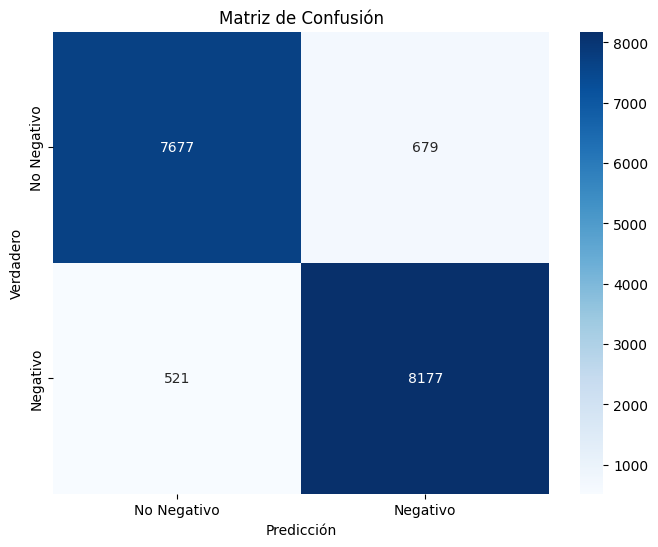

In [ ]:
# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["No Negativo", "Negativo"], yticklabels=["No Negativo", "Negativo"])
plt.xlabel("Predicción")
plt.ylabel("Verdadero")
plt.title("Matriz de Confusión")
plt.show()

> Interpretación de la Matriz:
1. Verdaderos Positivos (Negativo correctamente clasificados):
  * De los 8698 textos negativos reales, el modelo clasificó correctamente 8177 como negativos.
  * Esto indica un excelente desempeño al identificar opiniones negativas.
2. Verdaderos Negativos (No Negativo correctamente clasificados):
  * De los 8356 textos no negativos reales, el modelo clasificó correctamente 7677 como no negativos.
  * Este valor también es alto, reflejando que el modelo maneja bien ambas clases.
3. Falsos Positivos (No Negativo clasificado como Negativo):
 * 679 opiniones no negativas fueron mal clasificadas como negativas.
4. Falsos Negativos (Negativo clasificado como No Negativo):
  * 521 opiniones negativas reales fueron clasificadas como no negativas.
  * Este número es menor que los falsos positivos, lo que sugiere que el modelo es más preciso identificando opiniones negativas, algo deseable pues nuestro objetivo era priorizar atención a textos negativos.

Resumen General del Desempeño:
> * Equilibrio de Clases:
  * Nuestro modelo tiene un desempeño bien balanceado, ya que los errores (falsos positivos y negativos) están distribuidos de manera proporcional.
  * Este balance se refleja en las métricas como precisión, recall y F1, que son consistentes entre ambas clases.
* Errores Reducidos:
  * La cantidad de falsos negativos (521) y falsos positivos (679) es baja en comparación al total de ejemplos evaluados, indicando una clasificación robusta.
* Tendencias Observadas:
  * Nuestro modelo tiene una ligera tendencia a clasificar más como negativos que como no negativos, esto se debe a ese balanceo del conjunto de datos que hicimos cargado ligeramente a los negativos.


In [ ]:
# 3. Métrica Adicional: F1-Score para la clase `Negativo` (1)
from sklearn.metrics import f1_score
f1_negative = f1_score(y_test, y_pred, pos_label=1)
print(f"F1-Score para la clase 'Negativo' (1): {f1_negative:.4f}")

F1-Score para la clase 'Negativo' (1): 0.9316


> Interpretación:
* Este valor confirma que nuestro modelo maneja bien las opiniones negativas, logrando un equilibrio entre precisión y recall.
* Es particularmente importante dado que nuestro objetivo del análisis es priorizar opiniones negativas para su atención.



---



---
---

## **12. PROBANDO EL MODELO**



> En caso de usar un modelo descargado, descomenta las lineas necesarias para proceder, en caso dado solo con ejecutar desde la carga del archivo test y evauar con el modelo que se entreno en el momento.



> Puede tomar el modelo entrenado (para esta tarea con BERT) que se guardo para poder ejecutarlo para pruebas o evaluarlo con otro conjunto de datos, el cual puede ser deescargado de la siguienta liga: https://drive.google.com/file/d/1l2UQKbUJu4p9oMId-WZPinjCQIyl1nvZ/view?usp=drive_link


In [3]:
#!unzip saved_model_albert.zip -d ./models  #DESCOMENTA EN CASO DE NECESITARLO

Archive:  saved_model_albert.zip
   creating: ./models/saved_model_albert_1_PLN/
  inflating: ./models/saved_model_albert_1_PLN/tokenizer_config.json  
  inflating: ./models/saved_model_albert_1_PLN/special_tokens_map.json  
  inflating: ./models/saved_model_albert_1_PLN/tokenizer.json  
  inflating: ./models/saved_model_albert_1_PLN/model.safetensors  
  inflating: ./models/saved_model_albert_1_PLN/config.json  
  inflating: ./models/saved_model_albert_1_PLN/spiece.model  


Limpiamos cache

In [6]:
import torch

torch.cuda.empty_cache()

Evaluando el tipo de procesador a usar

In [7]:
# Verificar si se dispone de GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  #DESCOMENTA EN CASO DE NECESITARLO
print("Usando dispositivo:", device)   #DESCOMENTA EN CASO DE NECESITARLO

Usando dispositivo: cuda


Usando el modelo cargado anteriormente

In [8]:
# Ruta donde se guardó el modelo
#save_path = "./models/saved_model_albert_1_PLN"  #DESCOMENTA EN CASO DE NECESITARLO

# Cargar el modelo y el tokenizer
#tokenizer = AutoTokenizer.from_pretrained(save_path)  #DESCOMENTA EN CASO DE NECESITARLO
#model = AutoModelForSequenceClassification.from_pretrained(save_path).to(device)  #DESCOMENTA EN CASO DE NECESITARLO


---

Probando el modelo con ejemplos rapidos:

In [9]:
# Preparar los nuevos datos
new_texts = ["plenty articles written danger disease 's caused chinese made dog treats treats made china plenty healthy usa made treats available avoid costs latest information released tried return amazon said please buy treats.",
             "ww great n't get wrong still enjoy regular chips best close second great price",
             "since discovered product amazon 's turning back love pumpkin seeds local grocery stores going wonder happened pumpkin seed customer habit clearing shelves pumpkin seeds every time shopped stores",
             "Since we discovered this product through Amazon, there's no turning back.  We love these pumpkin seeds.  Our local grocery stores are going to wonder what happened to the pumpkin seed customer, because we were in the habit of clearing the shelves of pumpkin seeds every time we shopped in the stores."]
new_encodings = tokenizer(new_texts, truncation=True, padding=True, max_length=256, return_tensors="pt").to(device)

# Hacer predicciones
model.eval()  # Poner el modelo en modo de evaluación
with torch.no_grad():
    outputs = model(**new_encodings)
    predictions = torch.argmax(outputs.logits, axis=-1)

# Mostrar las predicciones
print("Predicciones:", predictions)

Predicciones: tensor([1, 0, 0, 0], device='cuda:0')



---

### **Evaluando el modelo con el dataset que se proporcione para test:**

Descargando el archivo test para evaluar



> puede tomar los archivos desde:
* sample_test : https://drive.google.com/file/d/19uttMgBux86iM2gptOSP0WDGbqrvddcP/view?usp=drive_link (Con etiquetas para test, con lo que se evaluo al final)
* test: https://drive.google.com/file/d/1H6IWH-UyWjo-O5HHpqyXOpWE2TRvF-dK/view?usp=drive_link (sin etiquetas, proporcionada por el profesor)



In [10]:
#df_val = pd.read_csv('sample_test.csv')  # Archivo con etiquetas para evaluar el modelo
df_val = pd.read_csv('test.csv') # El proporcionado por el profe
df_val

,Unnamed: 0,Summary,Text,Score,Negative
0,0,Very pleased with this product,Since we discovered this product through Amazo...,5,0
1,1,Great,My dogs have loved this product for 22+ Years....,5,0
2,2,"Fat free and taste free, sorry to say!",REally wanted to like this but it has no taste...,1,1
3,3,good stuff!,I really enjoy this product--I just purchased ...,5,0
4,4,HOW CAN YOU GO WRONG WITH GREENIES,Greenies are a great way to train your cat. If...,5,0
...,...,...,...,...,...
85262,85262,Poisons from China,I purchase almost daily from Amazon and recomm...,1,1
85263,85263,"Rich, Robust Flavor, and other good stuff, too.",The following are quotes from the box of Marle...,5,0
85264,85264,Green tea,I'm new to green tea so I purchased this produ...,3,0
85265,85265,Bigelow Chai Green Tea,What I was expecting was a chai tea similar to...,1,1


Obteniendo los textos a evaluar

In [11]:
#text_list = df_val["Text"].head(7100).tolist()
text_list = df_val["Text"].tolist()
#print(text_list)



> Para ejecutar la siguinte linea es necesario que se ejecute previamente las linas de codigo de las seccion **5. Limpieza y Preprocesamiento** (esto en caso que se haya procedido a trabajar bajo un modelo guardado), para proceder a realizar el tratamiento de los textos a evaluar con el modelo.



In [12]:
text_evaluation = preprocess_data(text_list)
new_encodings = tokenizer(list(text_evaluation), truncation=True, padding=True, max_length=256, return_tensors="pt").to(device)

<ipython-input-5-a98d433aeefd>:17: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()


In [13]:
from torch.utils.data import DataLoader, TensorDataset

# Creando un DataLoader para dividir los datos en lotes pequeños
batch_size = 16  # Ajustando según la capacidad de tu GPU
dataset = TensorDataset(new_encodings['input_ids'], new_encodings['attention_mask'])
dataloader = DataLoader(dataset, batch_size=batch_size)

all_predictions = []

model.eval()  # Modo evaluación
with torch.no_grad():
    for batch in dataloader:
        # Extrayendo lotes de input_ids y attention_mask
        input_ids, attention_mask = batch
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)

        # Realizando predicciones para el lote
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        predictions = torch.argmax(outputs.logits, axis=-1)

        # Guardando las predicciones en una lista
        all_predictions.extend(predictions.cpu().numpy())

### **13. Guardando los resultados**

In [ ]:
# Convertiendo las predicciones a una lista que contiene los valores predichos (0 o 1)
#predictions_list = predictions.tolist() if hasattr(predictions, "tolist") else list(predictions)

# Creando un DataFrame con las predicciones
df_predictions = pd.DataFrame(all_predictions, columns=["Prediction"])

# Guardando el DataFrame en un archivo CSV
output_csv_path = "predictions.csv"
df_predictions.to_csv(output_csv_path, index=False, header=False)

print(f"Archivo CSV guardado en: {output_csv_path}")

Archivo CSV guardado en: predictions.csv




---



---



> Esta parte correrla solo si se tiene las etiquetas para testear y evaluar el modelo.



In [14]:
label_list = df_val["Negative"].head(7100).tolist()
predictions_list = all_predictions

In [16]:
# Reporte de clasificación
print("Reporte de Clasificación:")
print(classification_report(label_list, predictions_list, target_names=["No Negativo", "Negativo"]))

Reporte de Clasificación:
              precision    recall  f1-score   support

 No Negativo       0.97      0.96      0.96      3497
    Negativo       0.96      0.97      0.97      3603

    accuracy                           0.96      7100
   macro avg       0.96      0.96      0.96      7100
weighted avg       0.96      0.96      0.96      7100




> Los resultados anteriores fueron con datos de otro dataset de muestra para poder evaluar el modelo




---



---



## 14. Resumen General del Comportamiento del Modelo
1. Desempeño Global:
  * Este modelo BERT logró un excelente desempeño con una exactitud del 96% en datos no vistos previamente.
  * Ambas clases (No Negativo y Negativo) fueron clasificadas con un alto nivel de precisión y recall, mostrando un balance sólido.
2. Desempeño en Opiniones Negativas:
  * El modelo destacó al identificar opiniones negativas con un F1-score del 97%, lo que es clave si nuestro objetivo era priorizar atención a comentarios negativos.
3. Desempeño en Opiniones No Negativas:
  * Aunque ligeramente menor, el desempeño para esta clase también fue sobresaliente con un F1-score del 96%.
4. Errores Cometidos:
  * Falsos positivos: Un pequeño porcentaje de opiniones no negativas fueron clasificadas como negativas.
  * Falsos negativos: Un porcentaje aún menor de opiniones negativas fue mal clasificado como no negativo, lo cual es aceptable para esta tarea.
5. Balance entre Clases:
  * El modelo manejó muy bien el balance de clases, lo cual es confirmado por métricas como el macro promedio (96%).
3. Capacidad de Generalización:
  * El desempeño en datos nuevos sugiere que el modelo está bien generalizado y no muestra signos evidentes de overfitting.
